In [2]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import re
import logging
import collections
from datetime import datetime as dt
import os
from pprint import pprint

#nltk
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams 

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

#gensim
import gensim
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
import gensim.downloader as api
from gensim.models import LdaModel, LdaMulticore
from gensim.utils import simple_preprocess, lemmatize
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from nltk.corpus import wordnet
# convert all tweets to lower case
def lower_case(tweet):
    return tweet.lower()

# remove @mentions
def remove_mentions(tweet):
    return re.sub(r'@[^\s]+', '',tweet)
    
# remove www and http URLs
def remove_links(tweet):
    return re.sub('((www.\S+)|(http\S+))','',tweet)

# remove all stop words and remove null
def remove_stopwords(tweet,stop_list):
    return [token.strip() for token in tweet if token.strip() not in stop_list and token.strip() != '']

# lemmatize with nltk WordNetLemmatizer
def lemmatize_words(tweet):
    return [lemmatizer.lemmatize(word) for word in tweet]

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = re.sub(r'www\S+', '', tweet) # remove www links
    tweet = re.sub(r'.*\.com', '', tweet)
    return tweet

def remove_consecutive(tweet):
    white_list = ['wpccc', 'unfccc', 'cccl', 'iccc']
    return [re.sub(r'([a-z])\1\1+', r'\1\1',word) for word in tweet if word not in white_list]

def remove_short_words(tweet):
    return [word for word in tweet if len(word) > 2]

def remove_digits(tweet):
    whitelist = ['p2','co2']
    return [re.sub(r'\d+','',word) for word in tweet if word not in whitelist]

def remove_apostrophes(tweet):
    return [re.sub(r"'s", "",word) for word in tweet]

def remove_symbols(tweet):
    #replace symbols with spaces
    return [re.sub(r'([^a-zA-Z\s]+?)', " ",word) for word in tweet]

def nltk_tag_to_wordnet_tag(nltk_tag):
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ
    # elif nltk_tag.startswith('V'):
    #     return wordnet.VERB
    # elif nltk_tag.startswith('N'):
    #     return wordnet.NOUN
    # elif nltk_tag.startswith('R'):
    #     return wordnet.ADV
    if nltk_tag.startswith('N'):
        return wordnet.NOUN
    else:          
        return None

# lemmatize with nltk WordNetLemmatizer
def lemmatize_words(tweet):
    # Pos tagging
    nltk_tagged = nltk.pos_tag(tweet)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))        
    return (lemmatized_sentence)

def remove_multispaces(tweet):
    #Replace multiple spaces with only 1 space
    return [re.sub(r' +', " ",word) for word in tweet]

def normalize_word(tweet):
    replacement_dict = {"peranakans":"peranakan","exhibit":"exhibition","gov't":'government', 'govt':'government','govts':'government',
                        'u.k.':'united kingdom','tv':'television','gov':'government','dc':'united state','d.c.':'united state',
                        'wwii': 'ww2','un':'united nations','us':'united states','uk':'united kingdom',
                        'artist': 'aritsts', 'child': 'children', 'kid': 'children', 'kids': 'children'}
    tweet = [replacement_dict[word] if word in replacement_dict.keys() else word for word in tweet]
    tweet = remove_consecutive(tweet)
    return tweet

def make_best_bigrams(myString):
    tokens = nltk.word_tokenize(myString)
    stop_bigrams = ['history singapore','museum singapore','history culture','couple hour', 'museum building', 'gallery singapore',
                   'visit museum', 'museum time']
    replace_bigrams = {}
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(nltk.collocations.BigramAssocMeasures.chi_sq, 800)
    bigrams = [' '.join(bigram) for bigram in bigrams]
    bigrams = [bigram for bigram in bigrams if bigram not in stop_bigrams]
    return [replace_bigrams[bigram] if bigram in replace_bigrams.keys() else bigram for bigram in bigrams]
    
# need to do the contractions dictionary
def expand_contractions(tweet):
    contractions = { "ain't": "am not",
                    "aren't": "are not",
                    "can't": "cannot",
                    "can't've": "cannot have",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "couldn't've": "could not have",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hadn't've": "had not have",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he had",
                    "he'd've": "he would have",
                    "he'll": "he will",
                    "he'll've": "he will have",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "that's": "that is",
                    "they'll": "they will",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'll": "we will",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what're": "what are",
                    "what've": "what have",
                    "when've": "when have",
                    "where'd": "where did",
                    "who's": "who is",
                    "who've": "who have",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you're": "you are",
                    "you've": "you have"}
    return [contractions[word] if word in contractions.keys() else word for word in tweet]

def remove_duplicates_in_sentence(tweet):
    # remove duplicates
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', tweet)

def wordcloud(counter):
    wc = WordCloud(width = 1200, height = 800, background_color = "white", max_words = 200)
    wc.generate_from_frequencies(counter)
    
    #plot
    fig = plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    
def process_alltweets(listtweets):

    new_listtweets = [lower_case(tweet) for tweet in listtweets]
    new_listtweets = [remove_mentions(tweet) for tweet in new_listtweets]
    new_listtweets = [remove_links(tweet) for tweet in new_listtweets]
    new_listtweets = [nltk.word_tokenize(tweet) for tweet in new_listtweets]
    new_listtweets = [remove_digits(tweet) for tweet in new_listtweets]
    new_listtweets = [normalize_word(tweet) for tweet in new_listtweets]
    
    new_listtweets = [expand_contractions(tweet) for tweet in new_listtweets]
    new_listtweets = [remove_apostrophes(tweet) for tweet in new_listtweets]
    
    new_listtweets = [remove_symbols(tweet) for tweet in new_listtweets]
    new_listtweets = [remove_multispaces(tweet) for tweet in new_listtweets]
    
    new_listtweets = [' '.join(tweet) for tweet in new_listtweets]
    new_listtweets = [nltk.word_tokenize(tweet) for tweet in new_listtweets]
    
    new_listtweets = [lemmatize_words(tweet) for tweet in new_listtweets]
    new_listtweets = [remove_stopwords(tweet,stop_list) for tweet in new_listtweets]
    new_listtweets = [remove_short_words(tweet) for tweet in new_listtweets]
    new_listtweets = [' '.join(tweet) for tweet in new_listtweets]
    new_listtweets = [remove_duplicates_in_sentence(tweet) for tweet in new_listtweets]

    return new_listtweets

<>:12: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \S
<ipython-input-3-073494db7f21>:12: DeprecationWarning: invalid escape sequence \S
  return re.sub('((www.\S+)|(http\S+))','',tweet)


In [4]:
import glob
path = r'Crawled_Data'                     # use your path
TA_files = glob.iglob(os.path.join(path, "*_tripadvisor.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_list = []
for f in TA_files:
    df_file = pd.read_csv(f)
    location = f.partition("_tripadvisor.csv")[0].partition("Crawled_Data\\")[2]
    df_file["Location"] = location
    df_list.append(df_file)
#df_from_each_file = (pd.read_csv(f) for f in TA_files)
TA_df = pd.concat(df_list, ignore_index=True)

In [5]:
TA_df

,username,num_posts,date_posted,date_experienced,rating,review_title,review_text,Location
0,IRHS,186,Yesterday,February 2020,40.0,Interesting way to view all of Asia,I spent a nice Sunday morning here. I enjoyed ...,asian_civilization_musueum
1,Sara Ng,10,2 Mar,March 2020,50.0,Place is very interesting with exhibitions,"Interesting place with many exhibitions, great...",asian_civilization_musueum
2,Travelswithboxers,67,Feb 2020,February 2020,40.0,Always worth a visit,We've been to singapore many times and always ...,asian_civilization_musueum
3,AyushBasu,194,Feb 2020,February 2020,50.0,(Min) 2 hours are recommended for this place!,The Asian Civilisations Museum is meant to sho...,asian_civilization_musueum
4,Jim_atl,"1,026",Feb 2020,February 2020,40.0,Interesting Museum,I spent a couple of hours exploring this museu...,asian_civilization_musueum
...,...,...,...,...,...,...,...,...
8575,Elizabeth O,36,Apr-11,Apr-11,50.0,very good contemporary art,Excellent contemporary art- good value unlike ...,sg_art_musueum
8576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sg_art_musueum
8577,HappyBelly,391,Aug-10,NaN,40.0,pleasantly surprised,"This is not the Louvre, but there were times w...",sg_art_musueum
8578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sg_art_musueum


In [6]:
# string = r"Crawled_Data\asian_civilization_musueum_tripadvisor.csv"
# string.partition("_tripadvisor.csv")[0].partition("Crawled_Data\\")[2]

In [7]:
#TA_df.columns
TA_df.shape

(8580, 8)

In [8]:
TA_df.dtypes

username             object
num_posts            object
date_posted          object
date_experienced     object
rating              float64
review_title         object
review_text          object
Location             object
dtype: object

In [9]:
duplicate_rows_df = TA_df[TA_df.duplicated()]
print('number of duplicate rows:', duplicate_rows_df.shape)

number of duplicate rows: (2962, 8)


In [10]:
duplicateRowsDF = TA_df[TA_df.duplicated()]
print(duplicateRowsDF)

     username num_posts date_posted date_experienced  rating review_title  \
1777      NaN       NaN         NaN              NaN     NaN          NaN   
1779      NaN       NaN         NaN              NaN     NaN          NaN   
1781      NaN       NaN         NaN              NaN     NaN          NaN   
1783      NaN       NaN         NaN              NaN     NaN          NaN   
1785      NaN       NaN         NaN              NaN     NaN          NaN   
...       ...       ...         ...              ...     ...          ...   
8570      NaN       NaN         NaN              NaN     NaN          NaN   
8572      NaN       NaN         NaN              NaN     NaN          NaN   
8574      NaN       NaN         NaN              NaN     NaN          NaN   
8576      NaN       NaN         NaN              NaN     NaN          NaN   
8578      NaN       NaN         NaN              NaN     NaN          NaN   

     review_text          Location  
1777         NaN  national_gallery  
1

In [11]:
TA_df = TA_df.dropna(thresh=2)
TA_df.shape

(5615, 8)

In [12]:
TA_df.isnull().values.any()

True

In [13]:
TA_df[TA_df.isnull().any(axis=1)]

,username,num_posts,date_posted,date_experienced,rating,review_title,review_text,Location
880,andrewjohnporter,142,Apr 2015,NaN,30.0,Ok but free,Renovations are taking place so only certain s...,asian_civilization_musueum
896,tom8787,52,Mar 2015,NaN,40.0,Educational,Pretty extensive museums for the history buffs...,asian_civilization_musueum
901,golem67,648,Mar 2015,NaN,40.0,Enjoyable visit!,"Worth the visit, the artistic Koran was intere...",asian_civilization_musueum
914,havaiisteve,143,Feb 2015,NaN,40.0,Excellent,About half the exhibits were closed due to ren...,asian_civilization_musueum
924,GlobeTrotting562042,7,Feb 2015,NaN,50.0,Amazing and interesting !!! Now it's free entr...,I planed to spend in this museum one hour. Fin...,asian_civilization_musueum
...,...,...,...,...,...,...,...,...
8531,Monster695,52,Feb-12,NaN,40.0,Second best place in Singapore to view Wu Guan...,Wander to the neighbouring art galleries to se...,sg_art_musueum
8533,Melvin S,25,Feb-12,NaN,40.0,Old Schoolhouse given a new lease of life - ar...,I'm not an art buff and many of the exhibits i...,sg_art_musueum
8541,robfbme,11,Jan-12,NaN,30.0,more modern than you might expect,"I am a member of this museum and enjoy art, ho...",sg_art_musueum
8577,HappyBelly,391,Aug-10,NaN,40.0,pleasantly surprised,"This is not the Louvre, but there were times w...",sg_art_musueum


In [14]:
TA_df.describe(include = np.object).transpose()

,count,unique,top,freq
username,5615,4719,KGB777,15
num_posts,5615,1035,5,62
date_posted,5615,237,Jul-16,91
date_experienced,5485,222,Dec-15,98
review_title,5614,4867,Interesting,41
review_text,5615,5613,We had a delightful Singaporean Lady guide who...,2
Location,5615,5,asian_civilization_musueum,1775


In [15]:
print(TA_df.isnull().sum())

username              0
num_posts             0
date_posted           0
date_experienced    130
rating                0
review_title          1
review_text           0
Location              0
dtype: int64


In [16]:
TA_df.head()

,username,num_posts,date_posted,date_experienced,rating,review_title,review_text,Location
0,IRHS,186,Yesterday,February 2020,40.0,Interesting way to view all of Asia,I spent a nice Sunday morning here. I enjoyed ...,asian_civilization_musueum
1,Sara Ng,10,2 Mar,March 2020,50.0,Place is very interesting with exhibitions,"Interesting place with many exhibitions, great...",asian_civilization_musueum
2,Travelswithboxers,67,Feb 2020,February 2020,40.0,Always worth a visit,We've been to singapore many times and always ...,asian_civilization_musueum
3,AyushBasu,194,Feb 2020,February 2020,50.0,(Min) 2 hours are recommended for this place!,The Asian Civilisations Museum is meant to sho...,asian_civilization_musueum
4,Jim_atl,"1,026",Feb 2020,February 2020,40.0,Interesting Museum,I spent a couple of hours exploring this museu...,asian_civilization_musueum


In [17]:
TA_df["Location"].nunique()

5

Number of Reviews for Each Unique Location (before dropping duplicates)

In [18]:
test_df = TA_df.groupby(["Location"]) \
            .agg({"Location" : pd.Series.count}) \
            .rename(columns = {"Location": "Num_Reviews"}) \
            .sort_values("Num_Reviews", ascending = False)
test_df.head()

,Num_Reviews
Location,
asian_civilization_musueum,1775
national_musueum,1545
national_gallery,1025
peranakan_musueum,875
sg_art_musueum,395


In [40]:
TA_df["review_text"] = TA_df.review_text.str.lower()
print("Number of Reviews that mention Friday:\n")
len(TA_df[TA_df['review_text'].str.contains('friday|fri')])

len(TA_df[TA_df['review_text'].str.contains('monday|mon')])

len(TA_df[TA_df['review_text'].str.contains('saturday|sat')])

len(TA_df[TA_df['review_text'].str.contains('sunday|sun')])




Number of Reviews that mention Friday:



C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


119

## Data Cleaning

In [17]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_list = stopwords.words('english')

## currently trying out using nltk pos tag - > Keep nouns

In [18]:
cleaned_TA_df = TA_df.copy()
cleaned_reviews = process_alltweets(cleaned_TA_df["review_text"])
cleaned_TA_df['cleaned_review_text'] = cleaned_reviews
cleaned_TA_df.sample(5)

,username,num_posts,date_posted,date_experienced,rating,review_title,review_text,Location,cleaned_review_text
1231,Suratrichard,956,Dec 2013,December 2013,50.0,Singapore should be proud of this attraction,Visited this excellent museum on a wet Sunday ...,asian_civilization_musueum,museum wet afternoon experience minute raffle ...
779,Richard L,50,Sep 2015,September 2015,20.0,Nothing interesting,It could have been a great museum but it is sm...,asian_civilization_musueum,museum toilet town
7055,Wendy H,369,Jul 2017,June 2017,40.0,a quiet place,The museum provides examples of the Pernakan c...,peranakan_musueum,museum example culture contribution developmen...
7465,penangnite,"1,421",Aug 2014,August 2014,50.0,Really excellent museum on the peranakan cultu...,"For visitors to Singapore, this should be a mu...",peranakan_musueum,visitor aspect singapore culture peranakans re...
4902,Ssaravanan1,48,Feb-18,Feb-18,50.0,Nice place for day out,Well maintained and organized. Good place to s...,national_musueum,place child history video display place history


In [19]:
print("Minimum review length")
print(cleaned_TA_df['cleaned_review_text'].apply(len).min())

print("Maximum review length")
print(cleaned_TA_df['cleaned_review_text'].apply(len).max())

print("Minimum number of words")
print(cleaned_TA_df['cleaned_review_text'].str.split().map(len).min())

print("Maximum number of words")
print(cleaned_TA_df['cleaned_review_text'].str.split().map(len).max())

Minimum review length
6
Maximum review length
3946
Minimum number of words
1
Maximum number of words
557


Distribution of length of words


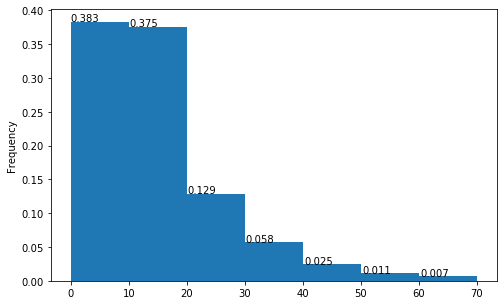

In [20]:
print("Distribution of length of words")
ax = cleaned_TA_df['cleaned_review_text'].str.split().map(len).plot.hist(bins=[0,10,20,30,40,50,60,70],figsize=(8,5),weights = np.ones_like(cleaned_TA_df.index) / len(cleaned_TA_df.index))
for p in ax.patches:
    ax.annotate(str('{0:.3f}'.format((p.get_height()))), (p.get_x() * 1.005, p.get_height() * 1.005))

Looking at popular words up to trigram

In [1]:
# def get_top_n_gram(corpus,a,n=None):
#     vec = CountVectorizer(ngram_range=(a,a)).fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:n]

# for i in range(1,4):
#     common_words = get_top_n_gram(cleaned_TA_df['cleaned_review_text'],i,20)
#     df_commonwords = pd.DataFrame(common_words, columns = ['cleaned_review_text' , 'count'])

#     ax = df_commonwords.plot(
#         kind='bar',
#         x = 'cleaned_review_text',
#         y = 'count',
#         title=str(i)+'-gram Common words Distribution')
#     ax.set_ylabel("Count")
#     plt.show()

In [ ]:
# texts = [nltk.word_tokenize(text) for text in cleaned_TA_df['cleaned_review_text']]
# bigrams = [make_best_bigrams(text) for text in cleaned_TA_df['cleaned_review_text']]

# documents = [texts[i] + bigrams[i] for i in range(len(texts))]

# dictionary = gensim.corpora.Dictionary(documents)

# # documents = texts

# dictionary = gensim.corpora.Dictionary(texts)
# print('Unigram Size before filtering:', len(dictionary))
# dictionary.filter_extremes(no_below=10)
# print('Unigram Size aftering filtering:', len(dictionary))

# dictionary.add_documents(bigrams)
# print('Total Vocabulary Size before filtering:', len(dictionary))

# dictionary.filter_extremes(no_below=5 , no_above = 0.3)
# print('Total Vocabulary Size after filtering:', len(dictionary), '\n')

# corpus = [dictionary.doc2bow(text) for text in documents]
# corpus[0]

In [ ]:
# print(bigrams)

In [21]:
docs = cleaned_TA_df['cleaned_review_text'].str.split().tolist()
word_count = collections.Counter()
for list in docs:
    for token in list: 
        word_count[token] += 1
word_count.most_common(20)
#word_count.most_common(20)[:2:-1]

[('museum', 5195),
 ('singapore', 3046),
 ('history', 2328),
 ('exhibition', 1865),
 ('gallery', 1751),
 ('building', 1726),
 ('art', 1687),
 ('time', 1490),
 ('place', 1377),
 ('exhibit', 1244),
 ('visit', 1243),
 ('hour', 1135),
 ('culture', 1092),
 ('tour', 1023),
 ('display', 953),
 ('child', 796),
 ('day', 787),
 ('collection', 765),
 ('lot', 728),
 ('city', 584)]

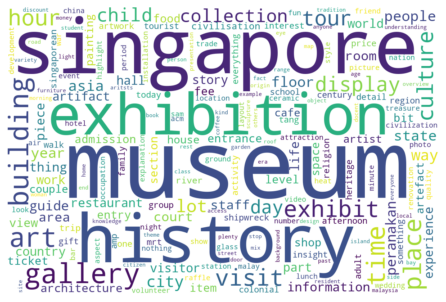

In [22]:
wordcloud(word_count)

### Create Dictionary from Processed Corpus

In [23]:
# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(docs)
print("Number of Vocabulary:", len(dictionary))
# Filter out words that occur less than 5 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=5,no_above=0.3)
print("\nFiltered Number of Vocabulary:", len(dictionary))

Number of Vocabulary: 5765

Filtered Number of Vocabulary: 1559


<B> Represent the corpus as a bag of words using the dictionary <B>

In [24]:
unigram_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [25]:
docs_freq = [dictionary[id] for doc in unigram_corpus for id, frequency in doc]
#print(docs_freq)
fdist = FreqDist(docs_freq)
fdist.most_common(20)

[('exhibition', 1370),
 ('building', 1339),
 ('time', 1209),
 ('place', 1103),
 ('art', 1084),
 ('visit', 1072),
 ('hour', 1045),
 ('exhibit', 1030),
 ('gallery', 1018),
 ('culture', 886),
 ('tour', 786),
 ('display', 782),
 ('day', 704),
 ('lot', 655),
 ('collection', 640),
 ('child', 571),
 ('way', 482),
 ('city', 482),
 ('asia', 431),
 ('people', 424)]

### Use unigram_corpus to do LDA

In [26]:
lda_model =  gensim.models.LdaMulticore(unigram_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)
#lda_model = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = 10, id2word=dictionary, passes=25, random_state= 0)

In [27]:
topics = lda_model.show_topics(formatted =True , num_topics = 10, num_words = 10)
for id, topic in topics:
    print("\nTopic " + str(id) +"\n", topic)


Topic 0
 0.026*"floor" + 0.023*"culture" + 0.022*"asia" + 0.020*"gallery" + 0.019*"time" + 0.018*"hour" + 0.016*"exhibit" + 0.015*"mrt" + 0.015*"place" + 0.012*"city"

Topic 1
 0.039*"exhibit" + 0.029*"building" + 0.024*"time" + 0.019*"visit" + 0.016*"artifact" + 0.016*"hour" + 0.014*"collection" + 0.014*"display" + 0.014*"place" + 0.013*"shipwreck"

Topic 2
 0.078*"art" + 0.052*"gallery" + 0.040*"building" + 0.036*"exhibition" + 0.025*"time" + 0.019*"visit" + 0.015*"work" + 0.014*"piece" + 0.014*"place" + 0.013*"exhibit"

Topic 3
 0.061*"art" + 0.054*"exhibition" + 0.047*"building" + 0.047*"gallery" + 0.025*"collection" + 0.024*"city" + 0.023*"court" + 0.019*"visit" + 0.018*"hall" + 0.015*"view"

Topic 4
 0.124*"place" + 0.030*"exhibition" + 0.030*"time" + 0.029*"display" + 0.027*"lot" + 0.017*"visit" + 0.016*"culture" + 0.016*"trip" + 0.013*"artefact" + 0.012*"people"

Topic 5
 0.043*"day" + 0.024*"area" + 0.024*"building" + 0.023*"visit" + 0.022*"year" + 0.022*"country" + 0.022*"lo

## Modifying Dictionary to include bigrams as well as removing domain specific stopwords

In [ ]:
#print(docs)

In [28]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=40, threshold = 80) # higher threshold fewer phrases.
bigram_phraser = Phraser(bigram)
trigram = gensim.models.Phrases(bigram[docs], min_count = 10)  
trigram_phrases = Phraser(trigram)

for idx in range(len(docs)):
    for token in trigram_phrases[docs[idx]]:
        if '_' in token:
            # Token is a bigram or trigram, add to document.
            docs[idx].append(token)

In [29]:
# Create new dictionary representation of the documents with bigrams.
new_dictionary = gensim.corpora.Dictionary(docs)
print("Number of Vocabulary:", len(new_dictionary))
# Filter out words that occur less than 5 documents, or more than 30% of the documents.
new_dictionary.filter_extremes(no_below=5,no_above=0.3)
print("\nFiltered Number of Vocabulary:", len(new_dictionary))

Number of Vocabulary: 5822

Filtered Number of Vocabulary: 1615


In [ ]:
# #remove domain specific stopwords
# print("Length of Dictionary:", len(new_dictionary))
# new_dictionary.filter_tokens(bad_ids=[new_dictionary.token2id['place'],
#                                       new_dictionary.token2id['visit'],
#                                       new_dictionary.token2id['exhibition'],
#                                       new_dictionary.token2id['exhibit'],
#                                       new_dictionary.token2id['time'],
#                                       new_dictionary.token2id['display'],
#                                       new_dictionary.token2id['lot'],
#                                       new_dictionary.token2id['people'],
#                                       new_dictionary.token2id['gallery'],
#                                       new_dictionary.token2id['hour'],
#                                       new_dictionary.token2id['thing'],
#                                       new_dictionary.token2id['floor'],
#                                       new_dictionary.token2id['ground'],
#                                       new_dictionary.token2id['way'],
#                                       new_dictionary.token2id['art'],
#                                       new_dictionary.token2id['room'],
#                                       new_dictionary.token2id['school'],
#                                       new_dictionary.token2id['level'],
#                                       new_dictionary.token2id['world'],
#                                       new_dictionary.token2id['year'],
#                                       new_dictionary.token2id['sam'],
#                                       new_dictionary.token2id['culture'],
#                                       new_dictionary.token2id['child'],
#                                       new_dictionary.token2id['state'],

                                      
                                      
#                                      ])
# print("Length of Dictionary after removing additional stopwords:", len(new_dictionary))

In [30]:
new_corpus = [new_dictionary.doc2bow(doc) for doc in docs]

In [31]:
new_docs_freq = [new_dictionary[id] for doc in new_corpus for id, frequency in doc]
#print(docs_freq)
fdist = FreqDist(new_docs_freq)
fdist.most_common(30)

[('exhibition', 1370),
 ('building', 1339),
 ('time', 1209),
 ('place', 1103),
 ('art', 1084),
 ('visit', 1072),
 ('hour', 1045),
 ('exhibit', 1030),
 ('gallery', 1018),
 ('culture', 886),
 ('tour', 786),
 ('display', 782),
 ('day', 704),
 ('lot', 655),
 ('collection', 640),
 ('child', 571),
 ('way', 482),
 ('city', 482),
 ('asia', 431),
 ('people', 424),
 ('year', 412),
 ('state', 408),
 ('floor', 379),
 ('guide', 377),
 ('staff', 352),
 ('information', 350),
 ('area', 349),
 ('thing', 341),
 ('restaurant', 336),
 ('life', 328)]

## Running LDA on New Dictionary
### this will be our baseline model (without hyperparameter tuning.)

In [32]:
new_lda_model =  gensim.models.LdaMulticore(corpus=new_corpus, 
                                   num_topics=10, 
                                   id2word=new_dictionary,                                    
                                   passes=10,
                                   chunksize=100,
                                   workers = 2)

In [33]:
new_topics = new_lda_model.show_topics(formatted =True , num_topics = 10, num_words = 10)
for id, topic in new_topics:
    print("\nTopic " + str(id) +"\n", topic)


Topic 0
 0.074*"building" + 0.060*"city" + 0.051*"gallery" + 0.037*"wedding" + 0.031*"hall" + 0.027*"court" + 0.024*"restaurant" + 0.024*"view" + 0.020*"night" + 0.019*"city_hall"

Topic 1
 0.121*"tour" + 0.053*"guide" + 0.047*"visit" + 0.046*"time" + 0.043*"culture" + 0.040*"hour" + 0.032*"state" + 0.027*"exhibit" + 0.023*"lot" + 0.020*"insight"

Topic 2
 0.046*"display" + 0.042*"culture" + 0.028*"exhibit" + 0.023*"year" + 0.022*"artifact" + 0.021*"world" + 0.021*"exhibition" + 0.018*"life" + 0.018*"collection" + 0.016*"asia"

Topic 3
 0.121*"peranakan" + 0.040*"culture" + 0.027*"people" + 0.022*"mrt" + 0.021*"food" + 0.021*"station" + 0.020*"house" + 0.019*"street" + 0.019*"heritage" + 0.017*"minute"

Topic 4
 0.220*"art" + 0.079*"gallery" + 0.052*"exhibition" + 0.045*"work" + 0.040*"piece" + 0.039*"building" + 0.033*"collection" + 0.032*"sam" + 0.029*"artist" + 0.018*"painting"

Topic 5
 0.085*"child" + 0.028*"place" + 0.028*"exhibition" + 0.027*"time" + 0.024*"exhibit" + 0.023*"ye

In [34]:
def get_topics_words(n,num_topics):
    topics_words = []
    for num ,topic in new_lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=n):
        topic_words = [word[0] for word in topic]
        topics_words += topic_words
    unique_words = set(topic_words)
    word_count = {}
    for word in unique_words:
        word_count[word] = topics_words.count(word)
    return sorted(word_count.items(), key=lambda item: item[1], reverse=True)

topics_words = get_topics_words(20,10)
print(topics_words)

[('place', 6), ('exhibit', 6), ('gallery', 3), ('people', 3), ('family', 2), ('beauty', 1), ('renovation', 1), ('local', 1), ('space', 1), ('event', 1), ('park', 1), ('admission_fee', 1), ('nothing', 1), ('photography', 1), ('friend', 1), ('admission', 1), ('group', 1), ('min', 1), ('mix', 1), ('amp', 1)]


## Finding optimal number of topics using coherence (but without removing domain stopwords)

In [35]:
##### Can take a long time to run.
limit=11; start=2; step=1;

model_list = []

score = {}
previous_coherence = None
coherence_values = []

for num_topic in range(start, limit, step):
    new_lda_model = gensim.models.ldamodel.LdaModel(
                corpus = new_corpus, num_topics = num_topic, id2word=new_dictionary, passes=10, random_state= 0,
                alpha='auto',eta='auto')
    model_list.append(new_lda_model)
    log_perplexity = new_lda_model.log_perplexity(new_corpus)
    perplexity = 2**(-log_perplexity)

    # Compute Coherence Score
    coherencemodel = CoherenceModel(model=new_lda_model, texts=docs, dictionary=new_dictionary, coherence='c_v')
    coherence_lda = coherencemodel.get_coherence()
    if previous_coherence == None:
        score[num_topic] = coherence_lda
        difference = 0
    else:
        difference = coherence_lda-previous_coherence
        score[num_topic] = coherence_lda
    print("Number of topics: {}\nCoherence Value: {}, Difference in Coherence: {}\n".format(num_topic,coherence_lda,difference))
    previous_coherence = coherence_lda
    coherence_values.append(coherence_lda)

Number of topics: 2
Coherence Value: 0.45736609734491784, Difference in Coherence: 0

Number of topics: 3
Coherence Value: 0.48765814160129956, Difference in Coherence: 0.03029204425638171

Number of topics: 4
Coherence Value: 0.5197229494317845, Difference in Coherence: 0.03206480783048499

Number of topics: 5
Coherence Value: 0.4849451555044374, Difference in Coherence: -0.034777793927347145

Number of topics: 6
Coherence Value: 0.4753051455071892, Difference in Coherence: -0.009640009997248178

Number of topics: 7
Coherence Value: 0.49249393913466466, Difference in Coherence: 0.01718879362747544

Number of topics: 8
Coherence Value: 0.4872279392353225, Difference in Coherence: -0.0052659998993421775

Number of topics: 9
Coherence Value: 0.46724175323606204, Difference in Coherence: -0.019986185999260442

Number of topics: 10
Coherence Value: 0.4703959975245115, Difference in Coherence: 0.0031542442884494593



In [ ]:
# new_log_perplexity = new_lda_model.log_perplexity(new_corpus)
# new_perplexity = 2**(-new_log_perplexity)
# print('Perplexity: ',new_perplexity)

# # Compute Coherence Score
# new_coherence_model_lda = CoherenceModel(model=new_lda_model, texts=docs, dictionary=new_dictionary, coherence='c_v')
# new_coherence_lda = new_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', new_coherence_lda)

In [ ]:
# pyLDAvis.enable_notebook()
# pyLDAvis.gensim.prepare(new_lda_model, new_corpus, new_dictionary)

In [40]:
#code from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel=new_lda_model, corpus=new_corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
# new_df_topic_sents_keywords = format_topics_sentences(ldamodel=new_lda_model, corpus=new_corpus, texts=docs)

# # Format
# new_df_dominant_topic = new_df_topic_sents_keywords.reset_index()
# new_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# new_df_dominant_topic.head(10)

## Hypertuning the model (number of topics as well as beta & eta) - not needed
Now we will attempt to find the optimal number of topics, based on eyeballing the clusters from pyLDAvis, about 6 clusters will be good, but we will plot the elbow graph to confirm

In [ ]:
# def compute_coherence_values(corpus, dictionary, k, a, b):
    
#     new_lda_model = gensim.models.LdaMulticore(corpus=new_corpus,
#                                            id2word=new_dictionary,
#                                            num_topics=k, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b,
#                                           )
    
#     coherence_model_lda = CoherenceModel(model=new_lda_model, texts=docs, dictionary=new_dictionary, coherence='c_v')
    
#     return coherence_model_lda.get_coherence()

# #     new_lda_model =  gensim.models.LdaMulticore(new_corpus, 
# #                                    num_topics = num_topics, 
# #                                    id2word = new_dictionary,                                    
# #                                    passes = 10,
# #                                    workers = 2)
# #     coherencemodel = CoherenceModel(model=new_lda_model, texts=docs, dictionary=new_dictionary, coherence='c_v')

In [ ]:
# #code from https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# import numpy as np
# import tqdm
# grid = {}
# grid['Validation_Set'] = {}
# # Topics range
# min_topics = 2
# max_topics = 15
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)
# # Alpha parameter
# alpha = np.arange(0.01, 1, 0.3).tolist()
# alpha.append('symmetric')
# alpha.append('asymmetric')
# # Beta parameter
# beta = np.arange(0.01, 1, 0.3).tolist()
# beta.append('symmetric')
# # Validation sets
# num_of_docs = len(new_corpus)
# corpus_sets = [# gensim.utils.ClippedCorpus(new_corpus, num_of_docs*0.25), 
#                # gensim.utils.ClippedCorpus(new_corpus, num_of_docs*0.5), 
#                #gensim.utils.ClippedCorpus(new_corpus, num_of_docs*0.75), 
#                new_corpus]
# corpus_title = ['100% Corpus']
# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }
# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=540)
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=new_dictionary, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
#     pbar.close()

## Choosing the best model hyperparameters that gives rise to highest coherence score

In [ ]:
# model_list_df = pd.read_csv("lda_tuning_results.csv")
# #model_list_df
# model_list_df.dtypes
# #model_list_df.columns

In [ ]:
# sub_model_list_df = model_list_df.loc[(model_list_df['Alpha'] == "0.01") & (model_list_df['Beta'] == "0.01")]
# sub_model_list_df

### Choosing optimal number of topics from rising part of graph

In [ ]:
# #model_list_df
# ax = plt.gca()

# sub_model_list_df.plot(figsize = (15,5), kind='line',x='Topics',y='Coherence',ax=ax)
# plt.show()

### tuning alpha and eta when number of topics is = 9

In [ ]:
# optimal_model_df = model_list_df.loc[(model_list_df['Topics'] == 5)]
# optimal_model_df = optimal_model_df.reset_index()
# optimal_model_df

In [ ]:
# optimal_model_df.loc[optimal_model_df['Coherence'].idxmax()]

## Hence the optimized LDA model has the parameters 4 number of topics (see above)
Let's examine how it looks like

In [39]:
optimal_lda_model = gensim.models.ldamodel.LdaModel(
                corpus = new_corpus, num_topics = 4, id2word=new_dictionary, passes=10, random_state= 0,
                alpha='auto',eta='auto')

In [41]:
new_topics = optimal_lda_model.show_topics(formatted =True , num_topics = 4, num_words = 10)
for id, topic in new_topics:
    print("\nTopic " + str(id) +"\n", topic)


Topic 0
 0.047*"culture" + 0.028*"peranakan" + 0.025*"display" + 0.018*"exhibit" + 0.018*"visit" + 0.018*"exhibition" + 0.017*"hour" + 0.017*"place" + 0.016*"time" + 0.015*"people"

Topic 1
 0.052*"tour" + 0.029*"place" + 0.027*"time" + 0.026*"hour" + 0.024*"guide" + 0.023*"exhibit" + 0.023*"visit" + 0.019*"building" + 0.017*"fee" + 0.016*"day"

Topic 2
 0.077*"art" + 0.063*"gallery" + 0.050*"building" + 0.030*"exhibition" + 0.016*"city" + 0.016*"place" + 0.016*"collection" + 0.016*"work" + 0.016*"court" + 0.015*"time"

Topic 3
 0.053*"child" + 0.035*"exhibition" + 0.019*"time" + 0.019*"exhibit" + 0.016*"year" + 0.013*"display" + 0.012*"lot" + 0.011*"floor" + 0.010*"activity" + 0.009*"life"


In [42]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_lda_model, new_corpus, new_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.125147 -0.006560       1        1  30.841013
2      0.169651 -0.108777       2        1  29.205769
1     -0.102942 -0.067498       3        1  21.544666
3      0.058439  0.182835       4        1  18.408548, topic_info=         Term         Freq        Total Category  logprob  loglift
19        art  1805.000000  1805.000000  Default  30.0000  30.0000
186     child   768.000000   768.000000  Default  29.0000  29.0000
31    gallery  1631.000000  1631.000000  Default  28.0000  28.0000
161      tour   975.000000   975.000000  Default  27.0000  27.0000
29    culture  1196.000000  1196.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
31    gallery   129.642471  1631.826660   Topic4  -4.6778  -0.8403
108     visit    99.128799  1224.983765   Topic4  -4.9462  -0.8219
11      place    93.583092  1317.446167   Topic4  -5.0038  -0.9522
136     state    85.228149   459.148926   Topic4  -5.0973   0.0083
20   building    86.164581  1743.939697   Topic4  -5.0864  -1.3153

[288 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
339       2  0.006825        activity
339       3  0.013650        activity
339       4  0.975958        activity
538       4  0.991213  activity_child
307       1  0.063901       admission
...     ...       ...             ...
91        1  0.258523            year
91        2  0.121905            year
91        3  0.138720            year
91        4  0.479213            year
1439      4  0.981493             yew

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [44]:
optimal_df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_model, corpus=new_corpus, texts=docs)

# Format
optimal_df_dominant_topic = optimal_df_topic_sents_keywords.reset_index()
optimal_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
optimal_df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9558,"culture, peranakan, display, exhibit, visit, e...","[sunday, morning, artifact, box, figurine, pic..."
1,1,0.0,0.8644,"culture, peranakan, display, exhibit, visit, e...","[place, exhibition, people, wedding, photo]"
2,2,0.0,0.9499,"culture, peranakan, display, exhibit, visit, e...","[time, drop, museum, exhibition, find, shipwre..."
3,3,0.0,0.4126,"culture, peranakan, display, exhibit, visit, e...","[civilisation, museum, art, culture, region, b..."
4,4,0.0,0.9672,"culture, peranakan, display, exhibit, visit, e...","[couple, hour, museum, ship, item, ship, quant..."
5,5,0.0,0.7888,"culture, peranakan, display, exhibit, visit, e...","[tang, shipwreck, expectation, exhibition, pot..."
6,6,0.0,0.6068,"culture, peranakan, display, exhibit, visit, e...","[museum, history, asia, century, artefact, par..."
7,7,1.0,0.4869,"tour, place, time, hour, guide, exhibit, visit...","[variety, item, diversity, singapore, ink, exh..."
8,8,0.0,0.6329,"culture, peranakan, display, exhibit, visit, e...","[exhibition, museum, exhibition, year, exhibit..."
9,9,0.0,0.6827,"culture, peranakan, display, exhibit, visit, e...","[museum, art, artifact, ceramic, furniture, fl..."


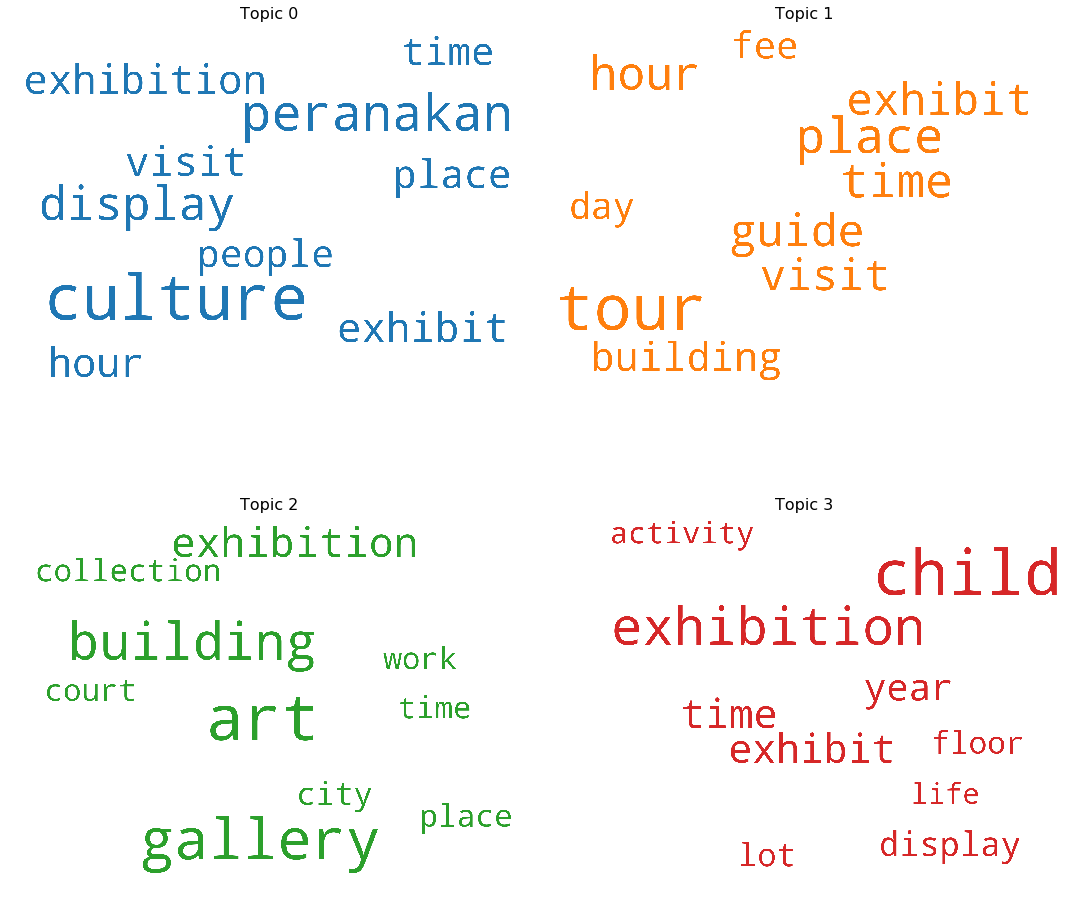

In [45]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()